In [1]:
import time
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython import display

from dataset import Dataset
from gen_video import gen_video, gen_batched_img

Camera position mean & std:
[ -1.9723758  -11.407406     0.36299774] [10.950828   5.4356313 11.073948 ]


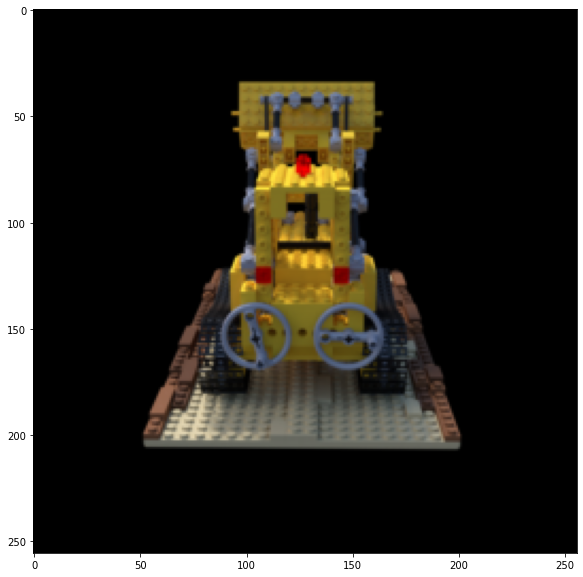

In [2]:
dataset = Dataset('../public/data/lego', 'blender')
H, W = dataset.H, dataset.W
plt.figure(figsize=(10, 10))
plt.imshow(dataset.images[0].permute(1,2,0))

In [3]:
i, j = np.meshgrid(np.arange(W, dtype=np.float32),
                   np.arange(H, dtype=np.float32), indexing='xy')
grid = np.stack([(i+1/W)/(W+1), 1-(j+1/H)/(H+1)], 0)
grid = torch.tensor(grid, device='cuda')
(grid.shape, grid.max())

(torch.Size([2, 256, 256]), tensor(1.0000, device='cuda:0'))

In [4]:
# https://github.com/skeeto/hash-prospector
#lowbias32
def hash(x):
    x = x.clone()
    # no uint32 in torch
    x += torch.iinfo(torch.int32).max // 2
    
    x ^= x >> 16
    x *= 0x7feb352d
    x ^= x >> 15
    x *= 0x846ca68b
    x ^= x >> 16
    return x

def ndhash(x):
    # hash over tensor of n dimensional points, where n is the first dimension
    # returns int tensor with first dimension removed
    y = hash(x[0])
    for i in range(x.shape[0] - 1):
        y = hash(y ^ x[i + 1])
    return y

In [5]:
# https://lemire.me/blog/2018/08/15/fast-strongly-universal-64-bit-hashing-everywhere/
# todo: string hash method instead of ndhash
_="""
[a, b, c] = torch.randint(torch.iinfo(torch.int64).max, (3,))
def hash32(x):
    low = x.type(torch.int32)
    high = (x >> 32).type(torch.int32)
    return ((a * low + b * high + c) >> 32).type(torch.int32)

def ndhash(x):
    y = hash32(x[0])
    for i in range(x.shape[0] - 1):
        y = hash32(y ^ x[i + 1])
    return y
"""

In [6]:
hash(torch.tensor([-2,-1,-0,0,1,2])) % 20000

tensor([11370, 19408, 10013, 10013, 17937, 12478])

In [7]:
def ray_box_intersection(rays, bounds, zero_miss=True):
    """Find intersection of rays with a box
    
    Args:
        rays: Tensor with shape [None, 6]. Each row should be
            [x, y, z, dx, dy, dz]
        bounds: Tensor with shape [3, 2] representing
            min and max coords of the box on each axis
        zero_miss: Set coords to 0 for missed rays
    
    Returns size [None, 2, 3] tensor with nearest and furthest
        intersection coords rescaled to [0, 1]
        and a size [None,] hit mask
    """
    ro = rays[:, :3]
    rd = rays[:, 3:]
    bounds_expanded = bounds.unsqueeze(0).expand(rays.shape[0], 3, 2)
    signs = (rd < 0).long().unsqueeze(-1)
    near_bounds = bounds_expanded.gather(-1, signs).squeeze(-1)
    t_near = ((near_bounds - ro) / rd).max(dim=-1)[0]
    far_bounds = bounds_expanded.gather(-1, 1-signs).squeeze(-1)
    t_far = ((far_bounds - ro) / rd).min(dim=-1)[0]
    pts = torch.stack([
        ro + rd * t_near.unsqueeze(-1),
        ro + rd * t_far.unsqueeze(-1)
    ], dim=1)
    pts_rescaled = (pts - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    hit_mask = t_near < t_far
    if zero_miss:
        pts_rescaled[~hit_mask] = 0
    return pts_rescaled, hit_mask

In [8]:
a = torch.randint(10, (3,2))
print(a)
ai = torch.argsort(a, dim=0, descending=True)
print(ai)
pts = [torch.zeros_like(a)]
for i in range(3):
    p = pts[-1].clone()
    p.scatter_(0, ai[None, i].expand(p.shape), 1)
    pts.append(p)
print(torch.stack(pts, dim=0))

tensor([[9, 0],
        [5, 5],
        [1, 0]])
tensor([[0, 1],
        [1, 0],
        [2, 2]])
tensor([[[0, 0],
         [0, 0],
         [0, 0]],

        [[1, 0],
         [0, 1],
         [0, 0]],

        [[1, 1],
         [1, 1],
         [0, 0]],

        [[1, 1],
         [1, 1],
         [1, 1]]])


In [9]:
def multiscale_hash(x, table, n_levels, interpolation='hcube'):
    # multiscale hash over tensor of n dimensional points, where n is the first dimension
    # returns int tensor where first dimension is removed, and two are added to the end
    # first is over levels, 2nd is over features
    
    # add extra coord that scales to the level
    x = torch.cat([x, torch.ones_like(x[:1])], dim=0)
    # tile along new levels dim
    x = torch.tile(x[..., None], (1,) * (x.ndim - 1) + (n_levels,))
    # scale for each level and convert to fract & int
    x = x * 2**torch.arange(1, n_levels + 1, device='cuda')
    
    #x = x * 4
    if interpolation == 'simplex':
        # use simplex noise lattice points
        # https://en.wikipedia.org/wiki/Simplex_noise
        ndim = x.shape[0] - 1
        # skew to hypercube (don't skew level coord)
        F = (np.sqrt(ndim + 1) - 1) / ndim
        xp = x.clone()
        xp[:-1] = xp[:-1] + x[:-1].sum(dim=0) * F
        xpb = xp.floor().int()
        xpi = xp % 1
        
        # get simplex corners
        xpisort = torch.argsort(xpi[:-1], dim=0, descending=True)
        ptsi = [torch.zeros_like(xpb[:-1])]
        for i in range(ndim):
            p = ptsi[-1].clone()
            p.scatter_(0, xpisort[None, i].expand(p.shape), 1)
            ptsi.append(p)
        ptsi = torch.stack(ptsi, dim=1)
        
        # unskew corners
        G = (1 - 1 / np.sqrt(ndim + 1)) / ndim
        pts = xpb[:-1, None].expand(ptsi.shape) + ptsi
        pts = pts - pts.sum(dim=0) * G
        
        # get weights (linear on max axis in hcube space, not like simplex noise)
        # todo: linear along normal of plane defined by other points
        _="""
        weights = (x[:-1, None, ...].expand(pts.shape) - pts).square()
        weights = weights.sum(dim=0).sqrt()
        weights = 1 - weights / weights.sum(dim=0, keepdim=True)
        """
        #print(weights.shape)
        weights, _ = torch.max((xpi[:-1, None].expand(ptsi.shape) - ptsi).abs(), dim=0)
        weights = 1 - weights
        #weights = weights / weights.sum(dim=0, keepdim=True)
        #print(weights.shape)
        
        # interpolate features
        # add 0 for level
        ptsi = torch.cat([ptsi, torch.zeros_like(ptsi[:1])], dim=0)
        y = table[ndhash(xpb[:, None, ...] + ptsi).long() % table.shape[0]]
        weights = weights[..., None].expand(y.shape)
        #return weights[1]
        #return y[0]
        y = (y * weights).sum(dim=0)
        return y
    elif interpolation == 'hcube':
        # multilinear hypercube interpolation
        ndim = x.shape[0] - 1
        b = torch.arange(2**ndim, device='cuda')
        b = b[None, :].expand(ndim, 2**ndim)
        p = 2**torch.arange(ndim, device='cuda')
        p = p[:, None].expand(ndim, 2**ndim)
        b = b // p % 2 # 2d tensor of all ndim-length bitstrings
        # add 0 for level (shouldn't be interpolated)
        b = torch.cat([b, torch.zeros_like(b[:1])], dim=0)
        
        # expand x to have addl dim at index 1 for each hcube corner
        x = x[:, None, ...].expand((x.shape[0], 2**ndim) + x.shape[1:])
        # expand b to x
        b = b[(...,) + (None,)*(x.dim() - 2)].expand(x.shape)
        # add end dim for table features
        weights = ((x % 1) - (1 - b))[:-1].abs().prod(dim=0)[..., None]
        
        y = table[ndhash(x.floor().int() + b).long() % table.shape[0]]
        #return y[0]
        y = (y * weights).sum(dim=0)
        return y
    else:
        y = table[ndhash(xi).long() % table.shape[0]]
        return y

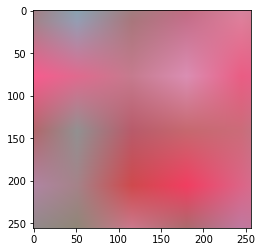

In [10]:
class HashModel(nn.Module):
    def __init__(self, table_size=int(1e6), table_channels=4,
                 n_levels_1=2, n_levels_2=8, n_scene_points=1, sample_coords=False):
        super().__init__()
        self.table = nn.Parameter((torch.rand(table_size, table_channels) * 2 - 1))
        self.n_levels_1 = n_levels_1
        self.n_levels_2 = n_levels_2
        
        self.l_s2 = nn.Linear(6 + table_channels * n_levels_1, 6)
        
        self.l_out_1 = nn.Linear(6 + table_channels * n_levels_2, 64)
        self.l_out_2 = nn.Linear(64, 3)
        
        self.sample_coords = sample_coords
        
        self.bounds = torch.tensor([[-1,1],[-1,1],[-1,1]], device='cuda') * 8
        
        if n_scene_points == 1:
            self.scene_points = torch.zeros(1, 3, device='cuda')
        else:
            # randomly generate scene points
            ray_sel = np.random.choice(dataset.rays.shape[0], n_scene_points)
            depth_mins = dataset.bds[ray_sel // (H * W), 0]
            depth_maxs = dataset.bds[ray_sel // (H * W), 1]
            r = np.random.rand(n_scene_points).astype(np.float32)
            dists = depth_mins + r * (depth_maxs - depth_mins)
            dists = torch.tensor(dists[:, None], device='cuda')
            self.scene_points = dataset.rays[ray_sel, :3] + dataset.rays[ray_sel, 3:] * dists
    
    def forward(self, rays, localization='origin'):
        local_rays = rays
        if localization == 'origin':
            # shift origins along ray so they're closest to 0,0,0
            ray_origins = rays[:, :3].repeat_interleave(self.scene_points.shape[0], dim=0)
            dirs_repeat = rays[:, 3:].repeat_interleave(self.scene_points.shape[0], dim=0)
            scene_points = self.scene_points.repeat(rays.shape[0], 1)
            ro_to_points = scene_points - ray_origins
            t = (ro_to_points * dirs_repeat).sum(dim=-1, keepdim=True)
            local_ro = ray_origins + dirs_repeat * t
            local_ro = local_ro.reshape(rays.shape[0], -1)
            # scale to object size
            local_ro = local_ro / 8
            local_rays = torch.cat([local_ro, rays[:, 3:]], dim=-1)
        elif localization == 'cube':
            pts, mask = ray_box_intersection(rays, self.bounds)
            # todo: handle missed rays
            local_rays = pts.reshape(pts.shape[0], -1)
        
        if self.sample_coords:
            feats = multiscale_hash(local_rays.permute(1, 0), self.table, self.n_levels_1)
            # combine features for each level onto one dim
            feats = feats.reshape(feats.shape[0], -1)
            feats = torch.cat([local_rays, feats], dim=-1)
            # resample table with new coords
            # todo: use different hash
            feats = self.l_s2(feats)
        else:
            feats = local_rays
        feats = multiscale_hash(feats.permute(1, 0), self.table, self.n_levels_2)
        feats = feats.reshape(feats.shape[0], -1)
        feats = torch.cat([local_rays, feats], dim=-1)
        # nonlinear projection to rgb
        h = self.l_out_1(feats).relu()
        y = self.l_out_2(h)
        return y

model = HashModel()
model.cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
    lambda epoch: max(0.8 ** epoch, 0.1))
losses = []

test_feats_to_rgb = nn.Conv2d(model.table.shape[-1], 3, 1, device='cuda')
y = multiscale_hash(grid - 0.2, model.table, model.n_levels_1)
y = torch.sum(y, dim=-2) / model.n_levels_1
# can comment next line out if table_channels >= 3
y = test_feats_to_rgb(y.permute(2,0,1)[None])[0].permute(1,2,0)
y = y * 0.5 + 0.5
plt.imshow(y[..., :3].detach().clip(0,1).cpu())

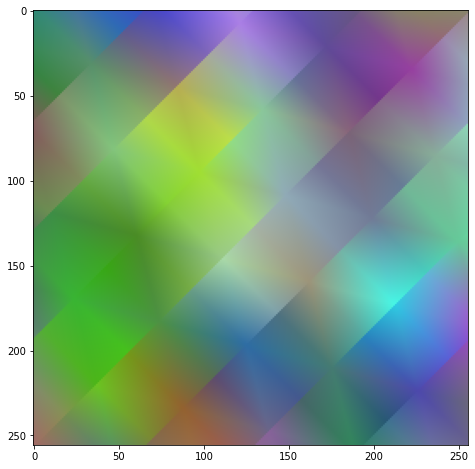

In [11]:
y = multiscale_hash(grid - 0, model.table, model.n_levels_1, interpolation='simplex')
y = torch.sum(y, dim=-2) / model.n_levels_1
# comment out if showing coords
y = y * 0.5 + 0.5
plt.figure(figsize=(8,8))
plt.imshow(y[..., :3].detach().clip(0,1).cpu())

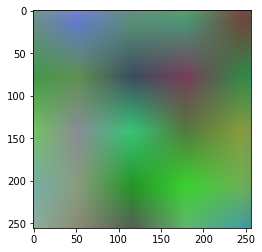

In [12]:
test_feats_to_rgb = nn.Conv2d(model.table.shape[-1], 3, 1, device='cuda')
y = multiscale_hash(grid - 0.2, model.table, model.n_levels_1, interpolation='hcube')
y = torch.sum(y, dim=-2) / model.n_levels_1
# can comment next line out if table_channels = 3
#y = test_feats_to_rgb(y.permute(2,0,1)[None])[0].permute(1,2,0) + 0.5
y = y * 0.5 + 0.5
plt.imshow(y[...,:3].detach().clip(0,1).cpu())

2000/2000
20s - eta 0s


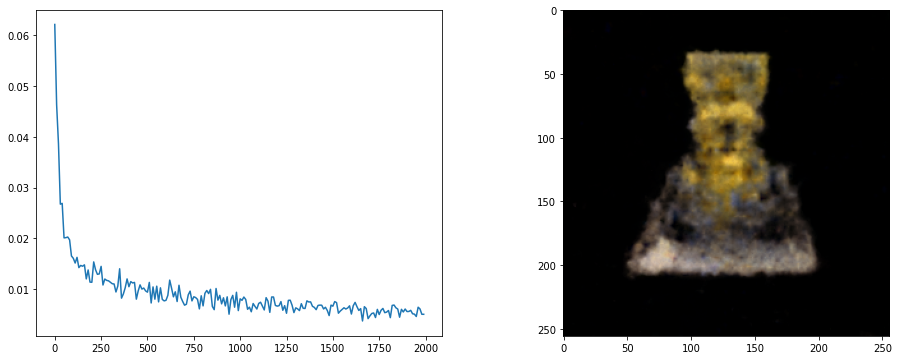

loss: 0.005099304486066103


In [13]:
train_st = time.time()
time_to_s = lambda t: (f'{int(t / 60)}m' if t >= 60 else '') + f'{int(t) % 60}s'

n_iter = int(2e3)
batch_size = 512

for i in range(n_iter):
    sel = np.random.choice(dataset.rays.shape[0], batch_size)
    pred = model(dataset.rays[sel])
    loss = loss_fn(pred, dataset.colors[sel])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 10 == 0:
        losses.append(loss.item())
    if (i + 1) % 200 == 0:
        display.clear_output(wait=True)
        print(f'{i+1}/{n_iter}')
        time_passed = time.time() - train_st
        eta = time_passed * (n_iter - i) / i
        print(f'{time_to_s(time_passed)} - eta {time_to_s(eta)}')
        plt.figure(figsize=(16, 6))
        plt.subplot(121)
        plt.plot(np.arange(len(losses)) * 10, losses)
        plt.subplot(122)
        with torch.no_grad():
            pred = gen_batched_img(model, dataset.rays[:H*W], batch_size)
            plt.imshow(pred.detach().clip(0,1).reshape(H, W, 3).cpu())
        plt.show()
        print(f'loss: {losses[-1]}')
    if (i + 1) % 400 == 0:
        scheduler.step()
        pass

In [14]:
gen_video(dataset, model, 'videos/out.mp4', batch_size=512)
display.clear_output()
display.display(display.HTML('<video src="videos/out.mp4" controls=true autoplay=true loop=true />'))